In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import databento as db
from databento import Historical
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# This is the second approach of the gold project concerning an exploration of potential factors that attribute to gold futures price movements

## The pipeline is as follows:
- ### to merge datasets from databento on front month futures prices, yahoo finance datasets on macro factors like strength of the U.S. dollar and interest rates, using proxies of dollar index and 10-year treasury rates, as well as fundamental factors from the world gold council website
- ### using merged dataset of the same granularity, attempt to understand multicolinearity between factors and higher correlated factors to futures prices and returns
- ### using higher correlated factors to attempt a factor model and test for in sample fit

Note: citing use of chatgpt for coding help

## Step 1.1 - Futures Dataset

### Obtain front month futures prices and sanity check for time series plot, granularity weekly

In [ ]:


client = Historical("db-T4MpVB3eDf7aE6ybYDu3G8GCexPwv")

# should be adjusted for availability of today's trade data
end = (pd.Timestamp.utcnow() - pd.Timedelta(days=1)).floor("D")
start = end - pd.Timedelta(days=2 * 365)

months = ["G","J","M","Q","V","Z"]
years = [4, 5, 6]
contracts = [f"GC{m}{y}" for y in years for m in months]

raw = client.timeseries.get_range(
    dataset="GLBX.MDP3",
    symbols=contracts,
    schema="ohlcv-1d",
    start=start,
    end=end,
).to_df()

raw["date"] = raw.index.normalize()

front_daily = (
    raw.sort_values(["date", "volume"])
       .groupby("date")
       .tail(1)
       .drop(columns=["date"])
)
front_daily.index = front_daily.index.normalize()

front_weekly = front_daily.resample("W-FRI").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum",
}).dropna()


/var/folders/b1/lfl3rf212fq4g372d7yytyyc0000gn/T/ipykernel_92001/1053331255.py:14: BentoWarning: The streaming request contained one or more days which have reduced quality: 2025-09-17 (degraded), 2025-09-24 (degraded). See: https://databento.com/docs/api-reference-historical/metadata/metadata-get-dataset-condition
  raw = client.timeseries.get_range(


In [6]:
front_weekly

,open,high,low,close,volume
ts_event,,,,,
2023-12-01 00:00:00+00:00,2064.8,2095.7,2051.2,2091.7,365274
2023-12-08 00:00:00+00:00,2094.4,2152.3,2010.6,2020.8,1080651
2023-12-15 00:00:00+00:00,2020.0,2062.9,1987.9,2033.8,835560
2023-12-22 00:00:00+00:00,2033.3,2083.0,2029.5,2064.5,643876
2023-12-29 00:00:00+00:00,2066.0,2098.2,2065.1,2071.8,414309
...,...,...,...,...,...
2025-10-31 00:00:00+00:00,4103.2,4123.8,3901.3,4013.4,1362170
2025-11-07 00:00:00+00:00,4001.0,4043.1,3935.7,4007.8,930538
2025-11-14 00:00:00+00:00,4007.2,4250.0,4004.2,4084.4,1198218


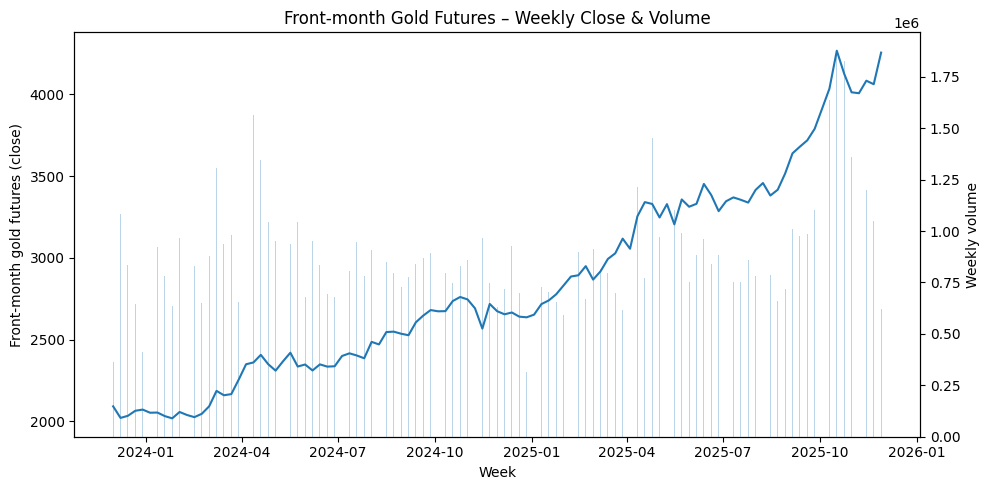

In [7]:
import matplotlib.pyplot as plt

fig, ax_price = plt.subplots(figsize=(10, 5))

ax_price.plot(front_weekly.index, front_weekly["close"])
ax_price.set_xlabel("Week")
ax_price.set_ylabel("Front-month gold futures (close)")

ax_vol = ax_price.twinx()
ax_vol.bar(front_weekly.index, front_weekly["volume"], alpha=0.3)
ax_vol.set_ylabel("Weekly volume")

plt.title("Front-month Gold Futures – Weekly Close & Volume")
plt.tight_layout()
plt.show()


In [ ]:
goldfuturesweekly = front_weekly.copy()

## Step 1.2 - Gold Balance Sheet (Fundamental S&D)

### this can be obtained through downloading the quarterly excel sheets and read excel to obtain gold balance sheet (supply and demand), this data is found here https://www.gold.org/goldhub/research/gold-demand-trends/gold-demand-trends-q1-2025#registration-type=google&just-verified=1

### although the website gives direct quarterly comparison, in the following chunk for look back 2 years in sample purposes, copying from the website will suffice

In [ ]:
import pandas as pd
import numpy as np


wgc_path = "/Users/leolu/Downloads/gdt-tables-q1-2025-EN.xlsx"
gb = pd.read_excel(wgc_path, sheet_name="Gold Balance")

# Row 3 (0-based) holds the year labels (2010, 2011, ..., 2024)
years_row = gb.iloc[3]

year_mask = years_row.apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x))
year_cols = years_row[year_mask].index     
years = years_row[year_mask].astype(int)    


series_col = "Unnamed: 1"

items_we_want = [
    "Mine production",
    "Net producer hedging",
    "Recycled gold",
    "Total supply",
    "Gold demand",
    "Total demand",
]


sub = gb[[series_col, *year_cols]].copy()
sub = sub.rename(columns={series_col: "item"})

# Filter only the rows we care about
sub = sub[sub["item"].isin(items_we_want)]

# Pivot to a time-series: index = year end, columns = items
wide = sub.set_index("item")[year_cols]

# Build a DatetimeIndex at year-end (e.g. 2010-12-31, ...)
dates = pd.to_datetime(years.astype(str) + "-12-31")
wide.columns = dates

wgc_annual = wide.T.sort_index()  


wgc_annual = wgc_annual.rename(
    columns={
        "Mine production": "mine_prod",
        "Net producer hedging": "net_hedging",
        "Recycled gold": "recycled",
        "Total supply": "total_supply",
        "Gold demand": "gold_demand",
        "Total demand": "total_demand",
    }
)


wgc_annual["supply_minus_demand"] = (
    wgc_annual["total_supply"] - wgc_annual["gold_demand"]
)
wgc_annual["supply_demand_ratio"] = (
    wgc_annual["total_supply"] / wgc_annual["gold_demand"]
)
wgc_annual["mine_share_supply"] = (
    wgc_annual["mine_prod"] / wgc_annual["total_supply"]
)


for col in ["supply_minus_demand", "supply_demand_ratio", "mine_share_supply"]:
    mu = wgc_annual[col].mean()
    sigma = wgc_annual[col].std()
    wgc_annual[col + "_z"] = (wgc_annual[col] - mu) / sigma


# resample from quarterly to weekly granularity
wgc_weekly = wgc_annual.resample("W-FRI").ffill()

print(wgc_annual.head())
print(wgc_weekly.head())


item          mine_prod  net_hedging     recycled  total_supply  gold_demand  \
3                                                                              
2010-12-31  2754.465101  -108.808409  1671.163847   4316.820540  4195.961176   
2011-12-31  2876.861923    22.525497  1626.331320   4525.718740  4748.822344   
2012-12-31  2957.201294   -45.315364  1636.762755   4548.648686  4711.782177   
2013-12-31  3166.325974   -27.939442  1195.308331   4333.694863  4527.493655   
2014-12-31  3271.508174   104.907298  1129.588570   4506.004042  4404.688252   

item        total_demand  supply_minus_demand  supply_demand_ratio  \
3                                                                    
2010-12-31   4316.820540           120.859363             1.028804   
2011-12-31   4525.718740          -223.103604             0.953019   
2012-12-31   4548.648686          -163.133492             0.965378   
2013-12-31   4333.694863          -193.798792             0.957195   
2014-12-31   4506.0

/Users/leolu/Downloads/CIP/.conda/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [9]:
wgc_weekly

item,mine_prod,net_hedging,recycled,total_supply,gold_demand,total_demand,supply_minus_demand,supply_demand_ratio,mine_share_supply,supply_minus_demand_z,supply_demand_ratio_z,mine_share_supply_z
3,,,,,,,,,,,,
2010-12-31,2754.465101,-108.808409,1671.163847,4316.820540,4195.961176,4316.820540,120.859363,1.028804,0.638077,-0.409990,-0.405582,-1.911106
2011-01-07,2754.465101,-108.808409,1671.163847,4316.820540,4195.961176,4316.820540,120.859363,1.028804,0.638077,-0.409990,-0.405582,-1.911106
2011-01-14,2754.465101,-108.808409,1671.163847,4316.820540,4195.961176,4316.820540,120.859363,1.028804,0.638077,-0.409990,-0.405582,-1.911106
2011-01-21,2754.465101,-108.808409,1671.163847,4316.820540,4195.961176,4316.820540,120.859363,1.028804,0.638077,-0.409990,-0.405582,-1.911106
2011-01-28,2754.465101,-108.808409,1671.163847,4316.820540,4195.961176,4316.820540,120.859363,1.028804,0.638077,-0.409990,-0.405582,-1.911106
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,3647.097981,69.395797,1234.430196,4950.923974,4507.614168,4950.923974,443.309806,1.098347,0.736650,0.509831,0.383264,0.259019
2024-12-13,3647.097981,69.395797,1234.430196,4950.923974,4507.614168,4950.923974,443.309806,1.098347,0.736650,0.509831,0.383264,0.259019
2024-12-20,3647.097981,69.395797,1234.430196,4950.923974,4507.614168,4950.923974,443.309806,1.098347,0.736650,0.509831,0.383264,0.259019


## Alternatively do the following, copying from the website directly

In [ ]:
import pandas as pd

quarters = [
    "2022Q1","2022Q2","2022Q3","2022Q4","2023Q1",
    "2023Q1","2023Q2","2023Q3","2023Q4","2024Q1",
    "2024Q3","2024Q4","2025Q1","2025Q2","2025Q3"
]

data = {
    # SUPPLY
    "mine_production": [
        843.1, 894.4, 956.3, 955.7, 856.0,      # 2022→2023Q1
        855.1, 900.9, 940.4, 939.9, 893.0,      # 2023Q1→2024Q1 block
        957.6, 944.9, 835.9, 904.3, 976.6       # 2024Q3→2025Q3
    ],
    "net_hedging": [
        25.9, 2.3, -25.9, -13.0, 8.1,           # 2022→2023Q1
        39.4, -19.5, 19.4, 15.9, -5.5,          # 2023→2024 block
        -6.5, -18.5, -7.1, -24.8, -8.0          # 2024Q3→2025Q3
    ],
    "recycled": [
        296.2, 285.3, 268.6, 290.5, 310.4,      # 2022→2023Q1
        311.9, 323.9, 289.2, 314.0, 350.8,      # 2023→2024
        324.8, 358.1, 348.7, 347.4, 344.4       # 2024Q3→2025Q3
    ],
    "total_supply": [
        1165.1, 1182.0, 1198.9, 1233.2, 1174.4, # 2022→2023Q1
        1206.4, 1205.3, 1249.0, 1269.7, 1238.3, # 2023→2024
        1275.9, 1284.4, 1177.5, 1226.8, 1313.1  # 2024Q3→2025Q3
    ],

    # DEMAND: jewellery
    "jewellery_fabrication": [
        516.4, 492.3, 582.3, 601.3, 508.6,
        531.0, 493.7, 581.7, 585.8, 535.0,
        546.5, 524.3, 424.4, 355.6, 419.2
    ],
    "jewellery_consumption": [
        475.3, 458.4, 526.1, 629.7, 477.9,
        488.9, 479.6, 520.2, 623.5, 479.0,
        460.0, 548.7, 382.4, 341.2, 371.3
    ],
    "jewellery_inventory": [
        41.1, 33.9, 56.2, -28.4, 30.7,
        42.1, 14.0, 61.5, -37.7, 56.0,
        86.6, -24.4, 42.0, 14.4, 47.8
    ],

    # DEMAND tech
    "technology": [
        81.0, 78.5, 77.0, 72.3, 70.0,
        71.2, 71.0, 75.4, 80.2, 78.6,
        82.9, 82.8, 80.4, 78.6, 81.7
    ],
    "electronics": [
        66.2, 64.6, 63.2, 58.0, 56.0,
        57.1, 57.2, 61.4, 65.5, 64.4,
        69.1, 68.8, 67.0, 65.8, 68.5
    ],
    "other_industrial": [
        12.0, 11.3, 11.3, 11.9, 11.6,
        11.7, 11.4, 11.7, 12.3, 11.9,
        11.6, 11.9, 11.3, 10.8, 11.1
    ],
    "dentistry": [
        2.7, 2.6, 2.5, 2.4, 2.4,
        2.4, 2.4, 2.3, 2.4, 2.3,
        2.2, 2.1, 2.1, 2.1, 2.0
    ],

    # INVESTMENT
    "investment": [
        558.4, 213.8, 103.9, 250.6, 273.7,
        275.3, 252.5, 155.8, 257.1, 198.6,
        364.8, 343.4, 551.5, 477.5, 537.2
    ],
    "total_bar_coin": [
        287.7, 261.2, 348.0, 340.3, 302.4,
        303.9, 273.3, 295.0, 312.9, 312.3,
        270.1, 324.7, 324.9, 307.0, 315.5
    ],
    "etf": [
        270.7, -47.4, -244.1, -89.6, -28.7,
        -28.6, -21.1, -139.2, -55.7, -113.7,
        94.7, 18.7, 226.6, 170.5, 221.7
    ],
    "central_banks": [
        82.7, 158.6, 458.6, 378.6, 228.4,
        286.2, 173.6, 357.7, 219.6, 289.7,
        199.5, 365.1, 241.7, 172.0, 219.9
    ],

    # AGGREGATES
    "gold_demand": [
        1238.5, 943.2, 1221.8, 1302.8, 1080.8,
        1163.7, 990.8, 1170.6, 1142.8, 1101.8,
        1193.8, 1315.6, 1298.0, 1083.8, 1257.9
    ],
    "otc_other": [
        -73.3, 238.8, -22.8, -69.7, 93.6,
        42.7, 214.5, 78.4, 126.9, 136.4,
        82.2, -31.2, -120.5, 143.1, 55.2
    ],
    "total_demand": [
        1165.1, 1182.0, 1198.9, 1233.2, 1174.4,
        1206.4, 1205.3, 1249.0, 1269.7, 1238.3,
        1275.9, 1284.4, 1177.5, 1226.8, 1313.1
    ],

    # PRICE
    "lbma_price": [
        1877.2, 1870.6, 1728.9, 1725.9, 1890.2,
        1889.9, 1975.9, 1928.5, 1971.5, 2069.8,
        2474.3, 2663.4, 2859.6, 3280.4, 3456.5
    ],
}

df_big = pd.DataFrame(data, index=pd.PeriodIndex(quarters, freq="Q"))
df_big.index = df_big.index.to_timestamp(how="end")

df_big.index.duplicated().any()
# Drop duplicate quarter-ends, keep the last occurrence for each date
df_q = df_big[~df_big.index.duplicated(keep="last")].sort_index()


df_weekly = df_q.resample("W-FRI").ffill()

sdweekly = df_weekly.copy()


## Step 1.3 - Obtain ten year and dollar index data from yfinance

In [10]:
import yfinance as yf
start = "2024-01-01"
end = "2025-11-28"
yf_data = yf.download(['^TNX','DX-Y.NYB'],start,end,auto_adjust=True)['Close']


[*********************100%***********************]  2 of 2 completed


In [11]:
yf_data

Ticker,DX-Y.NYB,^TNX
Date,,
2024-01-02,102.199997,3.946
2024-01-03,102.459999,3.907
2024-01-04,102.419998,3.991
2024-01-05,102.410004,4.042
2024-01-08,102.209999,4.002
...,...,...
2025-11-20,100.160004,4.106
2025-11-21,100.180000,4.063
2025-11-24,100.139999,4.038


In [12]:

df = yf_data.copy()

df.index = pd.to_datetime(df.index)
df = df.sort_index()

# convert to weekly frequency (Friday close)
df_weekly = df.resample("W-FRI").last()

print(df_weekly.head())
print(df_weekly.tail())


Ticker        DX-Y.NYB   ^TNX
Date                         
2024-01-05  102.410004  4.042
2024-01-12  102.400002  3.950
2024-01-19  103.290001  4.146
2024-01-26  103.470001  4.160
2024-02-02  103.919998  4.033
Ticker        DX-Y.NYB   ^TNX
Date                         
2025-10-31   99.800003  4.101
2025-11-07   99.599998  4.093
2025-11-14   99.269997  4.148
2025-11-21  100.180000  4.063
2025-11-28   99.599998  3.998


In [13]:
dollar10yearweekly = df_weekly.copy()

In [14]:
dollar10yearweekly

Ticker,DX-Y.NYB,^TNX
Date,,
2024-01-05,102.410004,4.042
2024-01-12,102.400002,3.950
2024-01-19,103.290001,4.146
2024-01-26,103.470001,4.160
2024-02-02,103.919998,4.033
...,...,...
2025-10-31,99.800003,4.101
2025-11-07,99.599998,4.093
2025-11-14,99.269997,4.148


In [16]:
goldfuturesweekly

,open,high,low,close,volume
ts_event,,,,,
2023-12-01 00:00:00+00:00,2064.8,2095.7,2051.2,2091.7,365274
2023-12-08 00:00:00+00:00,2094.4,2152.3,2010.6,2020.8,1080651
2023-12-15 00:00:00+00:00,2020.0,2062.9,1987.9,2033.8,835560
2023-12-22 00:00:00+00:00,2033.3,2083.0,2029.5,2064.5,643876
2023-12-29 00:00:00+00:00,2066.0,2098.2,2065.1,2071.8,414309
...,...,...,...,...,...
2025-10-31 00:00:00+00:00,4103.2,4123.8,3901.3,4013.4,1362170
2025-11-07 00:00:00+00:00,4001.0,4043.1,3935.7,4007.8,930538
2025-11-14 00:00:00+00:00,4007.2,4250.0,4004.2,4084.4,1198218


## Step 1.4 - Merge datasets

In [29]:
import pandas as pd


sd = sdweekly.copy()
sd.index = pd.to_datetime(sd.index)
sd = sd.sort_index()

gf = goldfuturesweekly.copy()
gf.index = pd.to_datetime(gf.index).tz_convert(None).normalize()
gf = gf.sort_index()

dx = dollar10yearweekly.copy()
dx.index = pd.to_datetime(dx.index)
dx = dx.sort_index()

start = "2022-04-01"
end   = "2025-12-31"

sd = sd.loc[start:end]
gf = gf.loc[start:end]
dx = dx.loc[start:end]

# INNER MERGES
# Merge supply/demand with futures
merged_1 = gf.join(sd, how="inner")

# Merge that result with dollar+TNX
merged_all = merged_1.join(dx, how="inner")

print(merged_all.head())
print(merged_all.tail())

# merged_all is your final aligned dataset 2024–2025  


              open    high     low   close  volume  mine_production  \
2024-01-05  2072.7  2088.1  2030.8  2052.6  651841            939.9   
2024-01-12  2052.6  2067.3  2017.3  2053.6  923874            939.9   
2024-01-19  2053.4  2062.8  2004.6  2031.8  780908            939.9   
2024-01-26  2031.8  2039.3  2004.0  2018.2  637152            939.9   
2024-02-02  2024.4  2083.2  2021.1  2057.1  965521            939.9   

            net_hedging  recycled  total_supply  jewellery_fabrication  ...  \
2024-01-05         15.9     314.0        1269.7                  585.8  ...   
2024-01-12         15.9     314.0        1269.7                  585.8  ...   
2024-01-19         15.9     314.0        1269.7                  585.8  ...   
2024-01-26         15.9     314.0        1269.7                  585.8  ...   
2024-02-02         15.9     314.0        1269.7                  585.8  ...   

            investment  total_bar_coin   etf  central_banks  gold_demand  \
2024-01-05       257.1

In [30]:
merged_all

,open,high,low,close,volume,mine_production,net_hedging,recycled,total_supply,jewellery_fabrication,...,investment,total_bar_coin,etf,central_banks,gold_demand,otc_other,total_demand,lbma_price,DX-Y.NYB,^TNX
2024-01-05,2072.7,2088.1,2030.8,2052.6,651841,939.9,15.9,314.0,1269.7,585.8,...,257.1,312.9,-55.7,219.6,1142.8,126.9,1269.7,1971.5,102.410004,4.042
2024-01-12,2052.6,2067.3,2017.3,2053.6,923874,939.9,15.9,314.0,1269.7,585.8,...,257.1,312.9,-55.7,219.6,1142.8,126.9,1269.7,1971.5,102.400002,3.950
2024-01-19,2053.4,2062.8,2004.6,2031.8,780908,939.9,15.9,314.0,1269.7,585.8,...,257.1,312.9,-55.7,219.6,1142.8,126.9,1269.7,1971.5,103.290001,4.146
2024-01-26,2031.8,2039.3,2004.0,2018.2,637152,939.9,15.9,314.0,1269.7,585.8,...,257.1,312.9,-55.7,219.6,1142.8,126.9,1269.7,1971.5,103.470001,4.160
2024-02-02,2024.4,2083.2,2021.1,2057.1,965521,939.9,15.9,314.0,1269.7,585.8,...,257.1,312.9,-55.7,219.6,1142.8,126.9,1269.7,1971.5,103.919998,4.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-05,3517.9,3655.5,3506.0,3639.8,1011158,904.3,-24.8,347.4,1226.8,355.6,...,477.5,307.0,170.5,172.0,1083.8,143.1,1226.8,3280.4,97.769997,4.086
2025-09-12,3635.0,3715.2,3621.7,3680.7,973968,904.3,-24.8,347.4,1226.8,355.6,...,477.5,307.0,170.5,172.0,1083.8,143.1,1226.8,3280.4,97.550003,4.061
2025-09-19,3680.2,3744.0,3660.5,3719.4,984747,904.3,-24.8,347.4,1226.8,355.6,...,477.5,307.0,170.5,172.0,1083.8,143.1,1226.8,3280.4,97.639999,4.139
2025-09-26,3721.3,3824.6,3718.1,3789.8,1104334,904.3,-24.8,347.4,1226.8,355.6,...,477.5,307.0,170.5,172.0,1083.8,143.1,1226.8,3280.4,98.150002,4.187


In [35]:
print(merged_all.dtypes)



open                     float64
high                     float64
low                      float64
close                    float64
volume                    uint64
mine_production          float64
net_hedging              float64
recycled                 float64
total_supply             float64
jewellery_fabrication    float64
jewellery_consumption    float64
jewellery_inventory      float64
technology               float64
electronics              float64
other_industrial         float64
dentistry                float64
investment               float64
total_bar_coin           float64
etf                      float64
central_banks            float64
gold_demand              float64
otc_other                float64
total_demand             float64
lbma_price               float64
DX-Y.NYB                 float64
^TNX                     float64
dtype: object


## Step 2 - Inspect Correlations

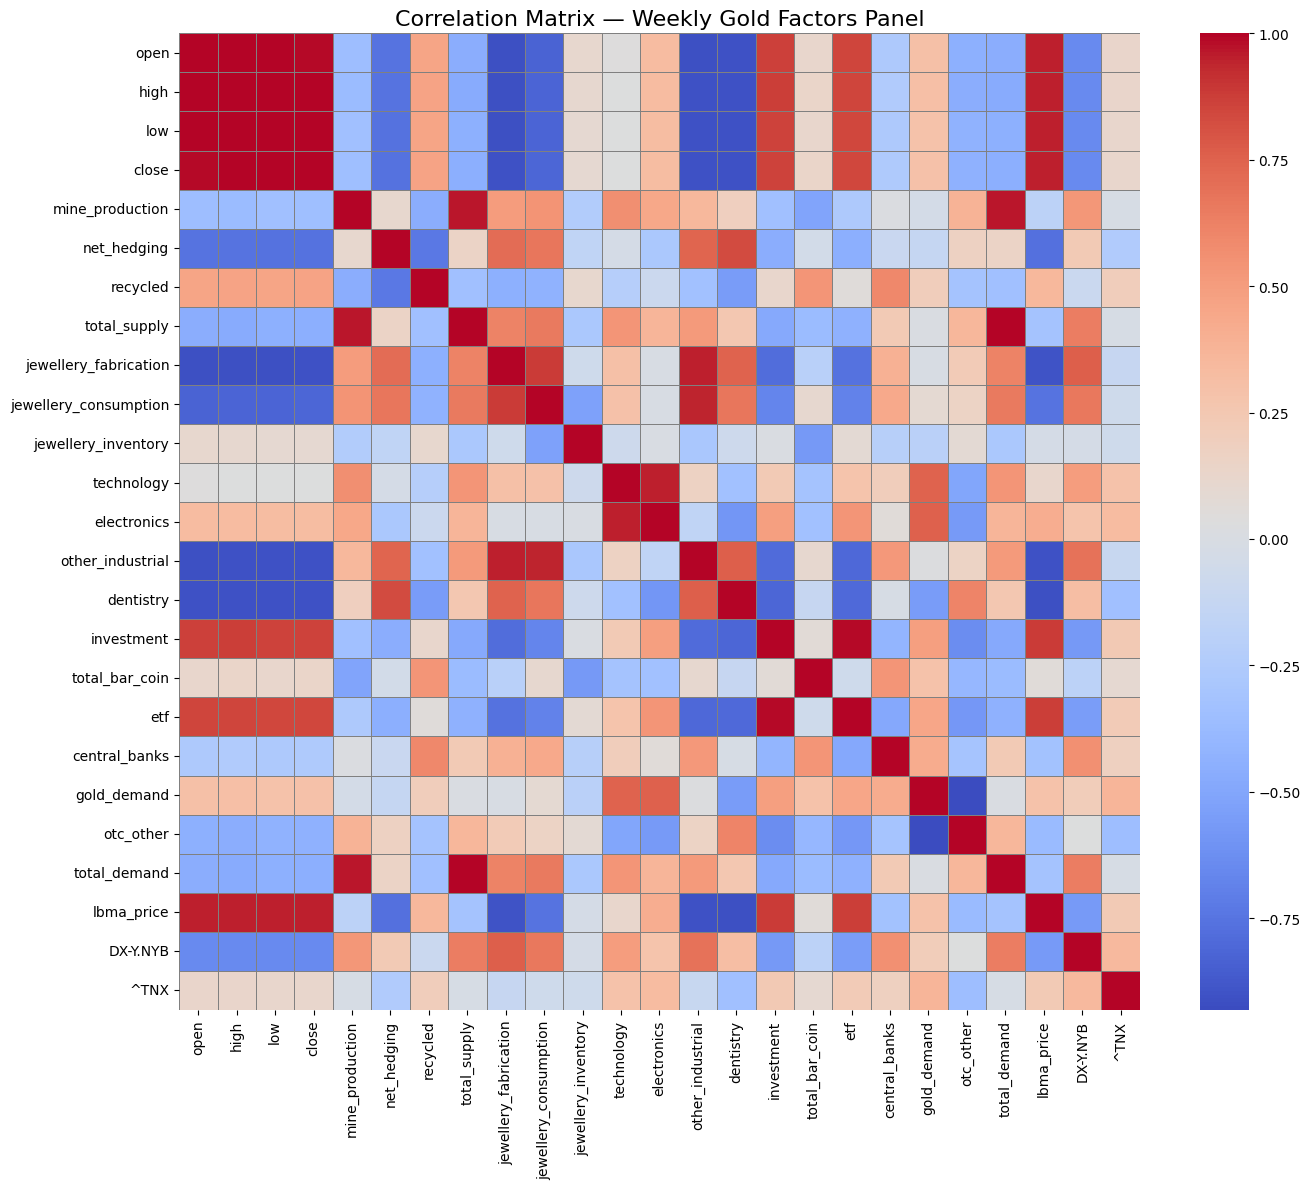

In [ ]:

temp = merged_all.copy()

# Drop any non-numeric columns if they somehow slipped in
temp = temp.select_dtypes(include=["float", "int"])

# Compute correlation matrix
corr = temp.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,         
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Correlation Matrix — Weekly Gold Factors Panel", fontsize=16)
plt.tight_layout()
plt.show()


### further look at correlation maps and rankings for fundamental factors, and macro factors, both values and returns

In [ ]:


# 1. Correlation with close price
corr_to_close = merged_all.corr()["close"]

# 2. Drop price columns so you don't cheat
price_cols = ["open", "high", "low", "close", "lbma_price"]
corr_to_close = corr_to_close.drop(labels=price_cols, errors="ignore")

# 3. Remove NaNs that come from constant columns
corr_to_close = corr_to_close.dropna()

# 4. Get the top positive and top negative correlations
top_pos = corr_to_close.sort_values(ascending=False).head(20)
top_neg = corr_to_close.sort_values(ascending=True).head(20)

print("Top POSITIVE correlations with close:")
print(top_pos)



Top POSITIVE correlations with close:
investment               0.862661
etf                      0.844686
recycled                 0.465301
electronics              0.327611
gold_demand              0.295182
volume                   0.134287
total_bar_coin           0.132304
^TNX                     0.118969
jewellery_inventory      0.097771
technology               0.031185
central_banks           -0.253325
mine_production         -0.346839
otc_other               -0.438586
total_supply            -0.450045
total_demand            -0.450045
DX-Y.NYB                -0.650612
net_hedging             -0.758858
jewellery_consumption   -0.818007
other_industrial        -0.903395
dentistry               -0.904215
Name: close, dtype: float64


In [39]:
df_ret = merged_all.pct_change()
corr = df_ret.corr()
corr["close"].sort_values(ascending=False)


close                    1.000000
high                     0.596907
low                      0.465310
recycled                 0.144549
total_demand             0.131912
total_supply             0.131912
central_banks            0.119176
mine_production          0.095342
jewellery_fabrication    0.071655
volume                   0.060303
other_industrial         0.038452
jewellery_inventory      0.037219
total_bar_coin           0.022177
technology               0.017424
jewellery_consumption    0.015657
electronics              0.011884
lbma_price               0.010942
gold_demand              0.006204
^TNX                    -0.007226
net_hedging             -0.032358
etf                     -0.105150
dentistry               -0.119781
open                    -0.128138
otc_other               -0.136499
investment              -0.143100
DX-Y.NYB                -0.312601
Name: close, dtype: float64

In [40]:
print("\nTop NEGATIVE correlations with close:")
print(top_neg)


Top NEGATIVE correlations with close:
jewellery_fabrication   -0.908646
dentistry               -0.904215
other_industrial        -0.903395
jewellery_consumption   -0.818007
net_hedging             -0.758858
DX-Y.NYB                -0.650612
total_demand            -0.450045
total_supply            -0.450045
otc_other               -0.438586
mine_production         -0.346839
central_banks           -0.253325
technology               0.031185
jewellery_inventory      0.097771
^TNX                     0.118969
total_bar_coin           0.132304
volume                   0.134287
gold_demand              0.295182
electronics              0.327611
recycled                 0.465301
etf                      0.844686
Name: close, dtype: float64


### We would discard ten year treasury because of low correlations, this could be due to the fact that 10 year reflects nominal instead of real rates, and/or gold is more impacted by short term rates, and possibly the weekly granularity isn't good enough for identifying correlations with rates

## Step 3 - Analysis 
### if were to follow logic and include dollar index and interest rates, which already proved to be low correlations, then the regression will yield a low r-squared

In [ ]:
df = merged_all.copy()

# Compute weekly returns for gold, dollar, interest rates
df["ret_gold"]   = df["close"].pct_change()
df["ret_dxy"]    = df["DX-Y.NYB"].pct_change()

# Keep the S&D factors you want (levels, not returns)
factors = [
    "investment",
    "etf",
    "total_demand",
    "net_hedging",
    "total_supply"
]

# Drop rows with missing values introduced by pct_change
df_model = df[["ret_gold", "ret_dxy"] + factors].dropna()

# 2. Build regression (OLS)
Y = df_model["ret_gold"]
X = df_model[["ret_dxy"] + factors]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               ret_gold   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.384
Date:                Sun, 30 Nov 2025   Prob (F-statistic):             0.0449
Time:                        15:20:05   Log-Likelihood:                 226.93
No. Observations:                  91   AIC:                            -441.9
Df Residuals:                      85   BIC:                            -426.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1689      0.124     -1.365   

### Discard total demand and total supply from anomolies in the previous regression, due to potentially quarterly data having near perfect correlations

In [ ]:

df = merged_all.copy()

# Compute weekly returns for gold, dollar, interest rates
df["ret_gold"]   = df["close"].pct_change()
df["ret_dxy"]    = df["DX-Y.NYB"].pct_change()



# Keep the S&D factors you want (levels, not returns)
factors = [
    "investment",
    "etf",
    "net_hedging"
]

# Drop rows with missing values introduced by pct_change
df_model = df[["ret_gold", "ret_dxy"] + factors].dropna()

# 2. Build regression (OLS)
Y = df_model["ret_gold"]
X = df_model[["ret_dxy"] + factors]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               ret_gold   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.492
Date:                Sun, 30 Nov 2025   Prob (F-statistic):             0.0490
Time:                        15:33:20   Log-Likelihood:                 225.95
No. Observations:                  91   AIC:                            -441.9
Df Residuals:                      86   BIC:                            -429.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0102      0.042     -0.245      

### Lower R-squared potentially overfit from previous step

###  Perform Lasso on returns with dollar index as returns, and factors as levels and not returns

In [ ]:
# 1. PREPARE DATA 
df = merged_all.copy()

df["ret_gold"] = df["close"].pct_change()
df["ret_dxy"]  = df["DX-Y.NYB"].pct_change()

factors = [
    "investment",
    "etf",
    "total_demand",
    "net_hedging",
    "total_supply"
]

df_model = df[["ret_gold", "ret_dxy"] + factors].dropna()

X = df_model[["ret_dxy"] + factors].values
y = df_model["ret_gold"].values

# 2. LASSO REGRESSION (standardized + cross-validated)

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=5, random_state=0))
])

lasso_pipe.fit(X, y)

lasso_coef = pd.Series(
    lasso_pipe.named_steps["lasso"].coef_,
    index=["ret_dxy"] + factors,
    name="lasso_coef"
)

print("=== LASSO COEFFICIENTS ===")
print(lasso_coef)

print("\nBest alpha:", lasso_pipe.named_steps["lasso"].alpha_)
print("\nLasso in-sample R²:", lasso_pipe.score(X, y))

# 3. REPORT SURVIVING FACTORS (non-zero coefficients)

print("\n=== NON-ZERO LASSO FACTORS ===")
print(lasso_coef[lasso_coef != 0])


=== LASSO COEFFICIENTS ===
ret_dxy        -0.004940
investment     -0.000000
etf            -0.000000
total_demand    0.000204
net_hedging    -0.000000
total_supply    0.000000
Name: lasso_coef, dtype: float64

Best alpha: 0.0017719810439324449

Lasso in-sample R²: 0.09281184030142453

=== NON-ZERO LASSO FACTORS ===
ret_dxy        -0.004940
total_demand    0.000204
Name: lasso_coef, dtype: float64


/Users/leolu/Downloads/CIP/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.493e-06, tolerance: 3.305e-06
  model = cd_fast.enet_coordinate_descent_gram(
/Users/leolu/Downloads/CIP/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-05, tolerance: 3.305e-06
  model = cd_fast.enet_coordinate_descent_gram(
/Users/leolu/Downloads/CIP/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features o

### if we ditch both dollar index and interest rates, and keep fundamental factors of supply and demand, regress only on flat price of front month futures, we will see unreasonably high r-squared, due to multicolinearity, and granularity issues, which will render the results uninterpretable

In [42]:
import pandas as pd
import statsmodels.api as sm

df = merged_all.copy()

df["ret_gold"]   = df["close"]

factors = [
    "net_hedging",
    "mine_production",
    "total_demand",
    "etf",
    "total_supply",
    "investment"
]

df_model = df[["ret_gold"] + factors].dropna()

# 2. Build regression (OLS)
Y = df_model["ret_gold"]
X = df_model[factors]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ret_gold   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     197.1
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.54e-45
Time:                        15:20:40   Log-Likelihood:                -584.21
No. Observations:                  92   AIC:                             1180.
Df Residuals:                      86   BIC:                             1196.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2344.5706   1462.949     

### Due to misalignment of granularity (fundamental factors from the world gold council being released on a quarterly basis), and misalignment for proxy variables (limitations of datasets for better proxies of macro factors in yfinance), we were unable to build a satisfactory factor model for gold. However, To conclude, similar to the other approach we were able to indentify factors that influences gold prices.